In [116]:
#Import dependencies - plotting
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# import matplotlib.cbook as cbook

In [117]:
#Import dependencies - dataframe, computation, storage, et.al.
import numpy as np
import pandas as pd
import re
import csv

In [118]:
#Import dependencies - date values and formats
import datetime as dt
from datetime import datetime
from datetime import date
from datetime import timedelta
import calendar

In [119]:
# Import dependencies - SQLalchemy
import sqlalchemy
from sqlalchemy import create_engine

In [120]:
# Import dependencies - browser exposure, API formatting
import json
import flask
from flask import Flask, jsonify

In [6]:
# Create an engine for the hawii.sqlite database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

### SQLalchemy -- Return LTM Precipitation Data

Records (rows) = 365


Text(0, 0.5, 'Inches')

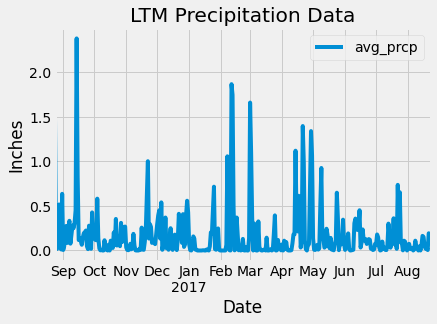

In [177]:
query = '''
    SELECT
        date,
        AVG(prcp) AS avg_prcp
    FROM
        measurement
    WHERE
        date > (SELECT date(MAX(date),'-1 year') FROM measurement)
    GROUP BY
        date
    ORDER BY
        date ASC
'''

# Save SQL query into dataframe
prcp_ltm_df = pd.read_sql(query, conn)

# Convert date column to date-format
prcp_ltm_df['date'] = pd.to_datetime(prcp_ltm_df['date'])

# Sort dataframe on date
prcp_ltm_df = prcp_ltm_df.sort_values('date')

# Set the index to date
prcp_ltm_df = prcp_ltm_df.set_index('date')

#Verification
print(f'Records (rows) = {len(prcp_ltm_df)}')

# Pandas Plotting to plot LTM precipitation
prcp_ltm_df.plot(title='LTM Precipitation Data', rot=0)
plt.xlabel('Date')
plt.ylabel('Inches')

### SQLalchemy - Station Data - Total Number of Weather Stations

In [16]:
query = '''
    SELECT
        COUNT(*) AS station_count
    FROM
        station
'''

ttl_station_count =  pd.read_sql(query, conn)
ttl_station_count = ttl_station_count.values[0]
print(f"Total weather stations = {ttl_station_count}")

Total weather stations = [9]


### SQLalchemy - Station Data - Number of Active Weather Stations for LTM Period

In [53]:
query = '''
    SELECT 
        COUNT (DISTINCT(s.name))
    FROM
        measurement m
        LEFT JOIN station s
        ON m.station = s.station
    WHERE
        m.prcp IS NOT NULL
        AND m.date > (SELECT date(MAX(date),'-1 year') FROM measurement)
'''

active_stations_ltm =  pd.read_sql(query, conn)
active_stations_ltm = active_stations_ltm.values[0]
print(f"Total weather stations active during LTM period = {active_stations_ltm}")

Total weather stations active during LTM period = [7]


### SQLalchemy - Station Data - Weather Stations Ordered by Precipitation Observations for Period 2010-2017

In [54]:
query = '''
    SELECT 
        s.station,
        s.name,
        COUNT(*) AS precip_obs
    FROM
        measurement m
        INNER JOIN station s
        ON m.station = s.station
    WHERE
        m.prcp IS NOT NULL
    GROUP BY
        m.station,
        s.name
    ORDER BY
        precip_obs DESC
'''
stations_by_activity_level_full_period_df =  pd.read_sql(query, conn)
stations_by_activity_level_full_period_df

,station,name,precip_obs
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00513117,"KANEOHE 838.1, HI US",2696
2,USC00519397,"WAIKIKI 717.2, HI US",2685
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2572
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2484
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",1937
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1932
7,USC00517948,"PEARL CITY, HI US",683
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",342


### SQLalchemy - Station Data - Weather Stations Ordered by Precipitation Observations for LTM Period

In [55]:
query = '''
    SELECT 
        s.station,
        s.name,
        COUNT(*) AS precip_obs
    FROM
        measurement m
        INNER JOIN station s
        ON m.station = s.station
    WHERE
        m.prcp IS NOT NULL
        AND m.date > (SELECT date(MAX(date),'-1 year') FROM measurement)
    GROUP BY
        m.station,
        s.name
    ORDER BY
        precip_obs DESC
'''
stations_by_activity_level_df =  pd.read_sql(query, conn)
stations_by_activity_level_df

,station,name,precip_obs
0,USC00519397,"WAIKIKI 717.2, HI US",358
1,USC00519281,"WAIHEE 837.5, HI US",351
2,USC00513117,"KANEOHE 838.1, HI US",342
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",327
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",313
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",264
6,USC00517948,"PEARL CITY, HI US",60


### SQLalchemy - Station Data - Weather Stations Ordered by Temperature Observations for Period 2010-2017

In [56]:
query = '''
    SELECT 
        s.station,
        s.name,
        COUNT(*) AS temp_obs
    FROM
        measurement m
        INNER JOIN station s
        ON m.station = s.station
    WHERE
        m.tobs IS NOT NULL
    GROUP BY
        m.station,
        s.name
    ORDER BY
        temp_obs DESC
'''
stations_tobs_activity_level_full_period_df =  pd.read_sql(query, conn)
stations_tobs_activity_level_full_period_df

,station,name,temp_obs
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00519397,"WAIKIKI 717.2, HI US",2724
2,USC00513117,"KANEOHE 838.1, HI US",2709
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,USC00517948,"PEARL CITY, HI US",1372
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


### SQLalchemy - Station Data - Weather Stations Ordered by Temperature Observations for LTM Period

In [57]:
query = '''
    SELECT 
        s.station,
        s.name,
        COUNT(*) AS temp_obs
    FROM
        measurement m
        INNER JOIN station s
        ON m.station = s.station
    WHERE
        m.tobs IS NOT NULL
        AND m.date > (SELECT date(MAX(date),'-1 year') FROM measurement)
    GROUP BY
        m.station,
        s.name
    ORDER BY
        temp_obs DESC
'''
stations_tobs_activity_level_df =  pd.read_sql(query, conn)
stations_tobs_activity_level_df

,station,name,temp_obs
0,USC00519397,"WAIKIKI 717.2, HI US",360
1,USC00519281,"WAIHEE 837.5, HI US",351
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",348
3,USC00513117,"KANEOHE 838.1, HI US",342
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",336
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",304
6,USC00517948,"PEARL CITY, HI US",182


### SQLalchemy - Station Data - Most Active Weather Station for 2010-2017 Period
(by both Precipitation Observations and Temperature Observations, as it happens) 

In [58]:
stations_by_activity_level_full_period_df

,station,name,precip_obs
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00513117,"KANEOHE 838.1, HI US",2696
2,USC00519397,"WAIKIKI 717.2, HI US",2685
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2572
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2484
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",1937
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1932
7,USC00517948,"PEARL CITY, HI US",683
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",342


In [60]:
most_active_station_full_period = stations_by_activity_level_full_period_df.values[0,1]

most_active_station_full_period_id = stations_by_activity_level_full_period_df.values[0,0]

# for convenience
name = most_active_station_full_period
name1 = name.title()
name2 = name1.replace(" ", "")
name3 = re.search(r"[a-zA-Z]*", name2).group()
name4 = re.sub(r"(?<=\w)([A-Z])", r" \1", name3)
most_active_station_full_period = name4

print(f"The {most_active_station_full_period} Weather Station was the most active for the period 2010-2017 with \
{stations_by_activity_level_full_period_df.values[0,2]} precipitation observations \nand \
{stations_tobs_activity_level_full_period_df.values[0,2]} temperature observations.")

The Waihee Weather Station was the most active for the period 2010-2017 with 2772 precipitation observations 
and 2772 temperature observations.


### SQLalchemy - Station Data - Most Active Weather Station for LTM Period
(by both Precipitation Observations and Temperature Observations, as it happens) 

In [32]:
most_active_station_ltm = stations_by_activity_level_df.values[0,1]

most_active_station_ltm_id = stations_by_activity_level_df.values[0,0]

# for convenience
name = most_active_station_ltm
name1 = name.title()
name2 = name1.replace(" ", "")
name3 = re.search(r"[a-zA-Z]*", name2).group()
name4 = re.sub(r"(?<=\w)([A-Z])", r" \1", name3)
most_active_station_ltm = name4

print(f"The {most_active_station_ltm} Weather Station was the most active for the LTM period with \
{stations_by_activity_level_df.values[0,2]} precipitation observations \nand {stations_tobs_activity_level_df.values[0,2]} \
temperature observations.")

The Waikiki Weather Station was the most active for the LTM period with 358 precipitation observations 
and 360 temperature observations.


### SQLalchemy - Station Data - Temperature Histogram of Most Active Station for Period 2010-2017

Records (rows) = 2772


Text(0, 0.5, 'Frequency')

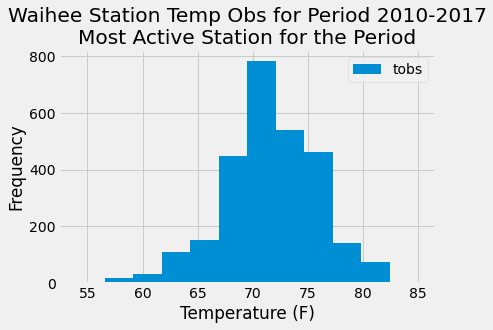

In [66]:
query = f'''
    SELECT 
        m.tobs
    FROM
        measurement m
    WHERE
        m.station = '{most_active_station_full_period_id}'        
    ORDER BY
        m.date ASC
'''
no1_active_tobs_station_df2 =  pd.read_sql(query, conn)
print(f"Records (rows) = {len(no1_active_tobs_station_df2)}")
no1_active_tobs_station_df2.head()

no1_active_tobs_station_df2.plot.hist(bins=12, title=f'{most_active_station_full_period} Station Temp Obs for Period \
2010-2017\nMost Active Station for the Period')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')

In [170]:
no1_active_tobs_station_df2.head()

,tobs
0,70.0
1,62.0
2,74.0
3,75.0
4,74.0


### SQLalchemy - Station Data - Temperature Histogram of Most Active Weather Station for the LTM Period

Records (rows) = 360


Text(0, 0.5, 'Frequency')

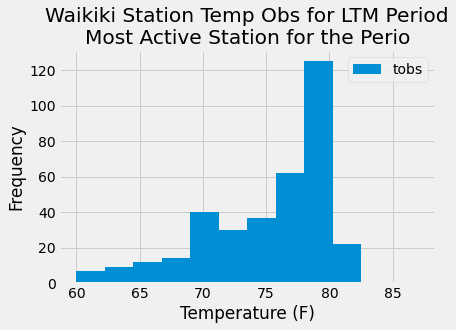

In [67]:
query = f'''
    SELECT 
        m.tobs
    FROM
        measurement m
    WHERE
        m.station = '{most_active_station_ltm_id}'
        AND m.date > (SELECT date(MAX(date),'-1 year') FROM measurement)
    ORDER BY
        m.date ASC
'''
no1_active_tobs_station_df =  pd.read_sql(query, conn)
print(f"Records (rows) = {len(no1_active_tobs_station_df)}")
no1_active_tobs_station_df.head()

no1_active_tobs_station_df.plot.hist(bins=12, title=f'{most_active_station_ltm} Station Temp Obs for LTM \
Period\nMost Active Station for the Perio')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')

### SQLalchemy - Station Data - Avg, High, and Low of Most Active Weather Station for the Period 2010-2017

In [78]:
query = f'''
    SELECT 
        MIN(m.tobs) AS low_temp,
        MAX(m.tobs) AS high_temp,
        AVG(m.tobs) AS avg_temp
    FROM
        measurement m
    WHERE
        m.station = '{most_active_station_full_period_id}'            
'''
temp_obs_full_period_df = pd.read_sql(query, conn)
print(f"\nLow, Mean, and High Temps for Period 2010-2017 for {most_active_station_full_period} Weather Station")
temp_obs_full_period_df


Low, Mean, and High Temps for Period 2010-2017 for Waihee Weather Station


,low_temp,high_temp,avg_temp
0,54.0,85.0,71.663781


### SQLalchemy - Station Data - Avg, High, and Low of Most Active Weather Station for the LTM Period

In [80]:
query = f'''
    SELECT 
        MIN(m.tobs) AS low_temp,
        MAX(m.tobs) AS high_temp,
        AVG(m.tobs) AS avg_temp
    FROM
        measurement m
    WHERE
        m.station = '{most_active_station_ltm_id}'
        AND m.date > (SELECT date(MAX(date),'-1 year') FROM measurement)    
'''
temp_obs_ltm_period_df = pd.read_sql(query, conn)
print(f"\nLow, Mean, and High Temps for LTM Period for {most_active_station_ltm} Weather Station")
temp_obs_ltm_period_df


Low, Mean, and High Temps for LTM Period for Waikiki Weather Station


,low_temp,high_temp,avg_temp
0,60.0,87.0,75.194444


### SQLalchemy - Station Data - Function for low, high, and average temperature for an user-selected period across all weather stations

In [138]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TMIN, and TAVG for a list of dates.
    
    Args:
        # start_date_str (string): A date string in the format %Y-%m-%d
        # end_date_str (string): A date string in the format %Y-%m-%d
    Returns:
        TMIN, TAVG, and TMAX
    """
    
    query = f'''
    SELECT 
        MIN(m.tobs) AS low_temp,
        MAX(m.tobs) AS high_temp,
        AVG(m.tobs) AS avg_temp
    FROM
        measurement m
    WHERE
        m.date BETWEEN '{start_date}'  AND '{end_date}'
    '''
    temp_obs_df = pd.read_sql(query, conn)
    
    temp_stats = tuple(temp_obs_df.values[0])
    
    return temp_stats

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

(62.0, 74.0, 69.57142857142857)


#### NOT ENOUGH TIME TO GENERATE FULLY METHODOLOGICALLY SOUND WEIGHTED AVERAGE

I believe the AVG formula used in the function 2 cells above is methodologically unsound for our purposes in that it implicitly weights by frequency of observations.  So, as an example, let's say you have a set of observations for 3 dates across 7 stations.  And let's say day 1 has 3 stations report temperature observations, day 2 has 4 stations report, and day 3 has all 7 stations report.  So, that means that day 3 accounts for 50% of the 3-day average temperature value you are calculating.  And let's say that days 1 and 2 are close to full-set average temperatures and day 3 is abnormally cold (beyond 1 STD vs. true full set).  That means our calculation (sample) would be distorting accurate representation of average temperature for a true full set.  It does so by not weighting each day slice equally.  BUT TO FIX the problem, let's say we take an average across all stations before we then subsequently take an average of those averages.  A subsequent issue might arise.  Let's say the stations that fail to report on days 1 and 2 are at higher elevations (typically colder average temperatures), but our solution averages the available reporting stations for a particular day.  That would mean for both days 1 and 2, on average we would be over-weighting warmer measurements (because the typically colder stations' values are not available).  So to REALLY FIX the issue, the methodologically sound thing to is to determine the typical variance between the stations (e.g., relative to station A, station B is typically 5 degrees F cooler, station C is 10 degrees F cooler,...)  That would compensation for systematic temperature differences (presumably due to altitude, which we have in the dataset BTW).  So, you would have a formula that would compensate for those differences in the missing station tobs values as you take a daily average across all stations before taking an average of those daily averages for the entire period.

### SQLalchemy - Station Data - Methodologically weighted average temperature for user-selected period - start and end date
(more accurate, but still not fully methodologically sound)

In [175]:
# This function called `calc_temps_better_method` will accept start date and end date in the format '%Y-%m-%d' 
# and return the weighted average temperature for that range of dates
def calc_temps_better_method(start_date, end_date):
    """TMIN, TMAX, and TWAVG for a list of dates.
    
    Args:
        # start_date_str (string): A date string in the format %Y-%m-%d
        # end_date_str (string): A date string in the format %Y-%m-%d
    Returns:
        TMIN, TMAX, and TWAVG
    """

    query = f'''
            SELECT
                MIN(dmin) as min_t,
                MAX(dmax) as max_t,
                AVG(davg) as wavg_t
            FROM 
                (SELECT
                    MIN(m.tobs) AS dmin,
                    MAX(m.tobs) AS dmax,
                    AVG(m.tobs) AS davg
                FROM
                    measurement m
                WHERE
                    m.date BETWEEN '{start_date}' AND '{end_date}'
                GROUP BY
                    m.date
                ORDER BY
                    m.date
                ) AS P;
            '''
    temps_better_method_df = pd.read_sql(query, conn)
    
    temps_better_method = tuple(temps_better_method_df.values[0])
    
    return temps_better_method

# function usage example
print(calc_temps_better_method('2012-02-28', '2012-03-05'))

(62.0, 74.0, 69.48837868480726)


### SQLalchemy - Station Data - Methodologically weighted average temperature for user-selected period - start date only 
(more accurate, but still not fully methodologically sound)

In [176]:
# This function called `calc_2_temps_better_method` will accept a start date without end date in the format '%Y-%m-%d' 
# and return the weighted average temperature for a range including that date and all dates forward
def calc_2_temps_better_method(start_date):
    """TMIN, TMAX, and TWAVG for a list of dates.
    
    Args:
        # start_date_str (string): A date string in the format %Y-%m-%d
    Returns:
        TMIN, TMAX, and TWAVG
    """

    query = f'''
            SELECT
                MIN(dmin) as min_t,
                MAX(dmax) as max_t,
                AVG(davg) as wavg_t
            FROM 
                (SELECT
                    MIN(m.tobs) AS dmin,
                    MAX(m.tobs) AS dmax,
                    AVG(m.tobs) AS davg
                FROM
                    measurement m
                WHERE
                    m.date >= '{start_date}'
                GROUP BY
                    m.date
                ORDER BY
                    m.date
                ) AS P;
            '''
    temps_2_better_method_df = pd.read_sql(query, conn)
    
    temps_2_better_method = tuple(temps_2_better_method_df.values[0])
    
    return temps_2_better_method

# function usage example
print(calc_2_temps_better_method('2012-02-28'))

(53.0, 87.0, 73.53610061622796)


#### FURTHER OBSERVATION
If I read the instructions right, this isn't a forensic analysis.  Rather, we're supposed to be planning a vacation (in the future).  We want to know record high, record low, and average temperature for the historical temperature data set.  Basically, for TMAX, if we're taking a hypothetical 2 day trip (let's say April 4, 2021 thru April 5, 2021), we want to know the record high temperature every April 4 and every April 5 from 2010 thru 2017.  And similarly so, for TMIN, it's lows across every April 4 and every April 5 from 2010 thru 2017.  And for TAVG, it's similar but with the issues I cited above about weighting.

### SQLalchemy - Station Data - Vacation Planner Using Any Dates in the Future 
(more accurate, but still not fully methodologically sound)

In [158]:
# This function called `vaca_calc_temp` will accept start date and end date in the format '%Y-%m-%d' 
# for vacations for any dates in the future and return the low, high, and weighted average temperature for 
# that range of dates.

def vaca_calc_temp(vaca_start_date, vaca_end_date):
    
    vacation_dates_x = []
    vacation_dates = [vaca_start_date,vaca_end_date]
    for date_x in vacation_dates:
        vals_x = date_x.split("-")
        vacation_date_x = '2021' + "-" + vals_x[1] + "-" + vals_x[2]
        vacation_dates_x.append(vacation_date_x)
    
    """TMIN, TMAX, and TWAVG for a list of dates.
    
    Args:
        # start_date_str (string): A date string in the format %Y-%m-%d
        # end_date_str (string): A date string in the format %Y-%m-%d
    Returns:
        TMIN, TMAX, and TWAVG
    """

    query = f'''

    SELECT 
        MIN(dmin) as min_t,
        MAX(dmax) as max_t,
        AVG(davg) as wavg_t
    FROM 
        (SELECT
            MIN(m.tobs) AS dmin,
            MAX(m.tobs) AS dmax,
            AVG(m.tobs) AS davg
            
         FROM
            measurement m
         WHERE
            m.date BETWEEN -- 2010
                (SELECT date('{vacation_dates_x[0]}','-11 year') FROM measurement) 
                AND (SELECT date('{vacation_dates_x[1]}','-11 year') FROM measurement)

            OR m.date BETWEEN -- 2011
                (SELECT date('{vacation_dates_x[0]}','-10 year') FROM measurement) 
                AND (SELECT date('{vacation_dates_x[1]}','-10 year') FROM measurement)

            OR m.date BETWEEN -- 2012
                (SELECT date('{vacation_dates_x[0]}','-9 year') FROM measurement) 
                AND (SELECT date('{vacation_dates_x[1]}','-9 year') FROM measurement)

            OR m.date BETWEEN -- 2013
                (SELECT date('{vacation_dates_x[0]}','-8 year') FROM measurement) 
                AND (SELECT date('{vacation_dates_x[1]}','-8 year') FROM measurement)

            OR m.date BETWEEN -- 2014
                (SELECT date('{vacation_dates_x[0]}','-7 year') FROM measurement) 
                AND (SELECT date('{vacation_dates_x[1]}','-7 year') FROM measurement)

            OR m.date BETWEEN -- 2015
                (SELECT date('{vacation_dates_x[0]}','-6 year') FROM measurement) 
                AND (SELECT date('{vacation_dates_x[1]}','-6 year') FROM measurement)

            OR m.date BETWEEN -- 2016
                (SELECT date('{vacation_dates_x[0]}','-5 year') FROM measurement) 
                AND (SELECT date('{vacation_dates_x[1]}','-5 year') FROM measurement)

            OR m.date BETWEEN -- 2017
                (SELECT date('{vacation_dates_x[0]}','-4 year') FROM measurement) 
                AND (SELECT date('{vacation_dates_x[1]}','-4 year') FROM measurement)

         GROUP BY
            m.date
         ORDER BY
            m.date
        ) AS P;
        '''
    
    vaca_temp_df = pd.read_sql(query, conn)
    
    vaca_temp = tuple(vaca_temp_df.values[0])
    
    return vaca_temp

# function usage example
print(vaca_calc_temp('2027-04-04', '2027-04-18'))

(58.0, 82.0, 72.08811507936507)
